In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## READ DATA

In [2]:
train = pd.read_csv('../Dataset/FitbitTrainData.csv')
test = pd.read_csv('../Dataset/FitbitTestData.csv')

## FEATURE SELECTION

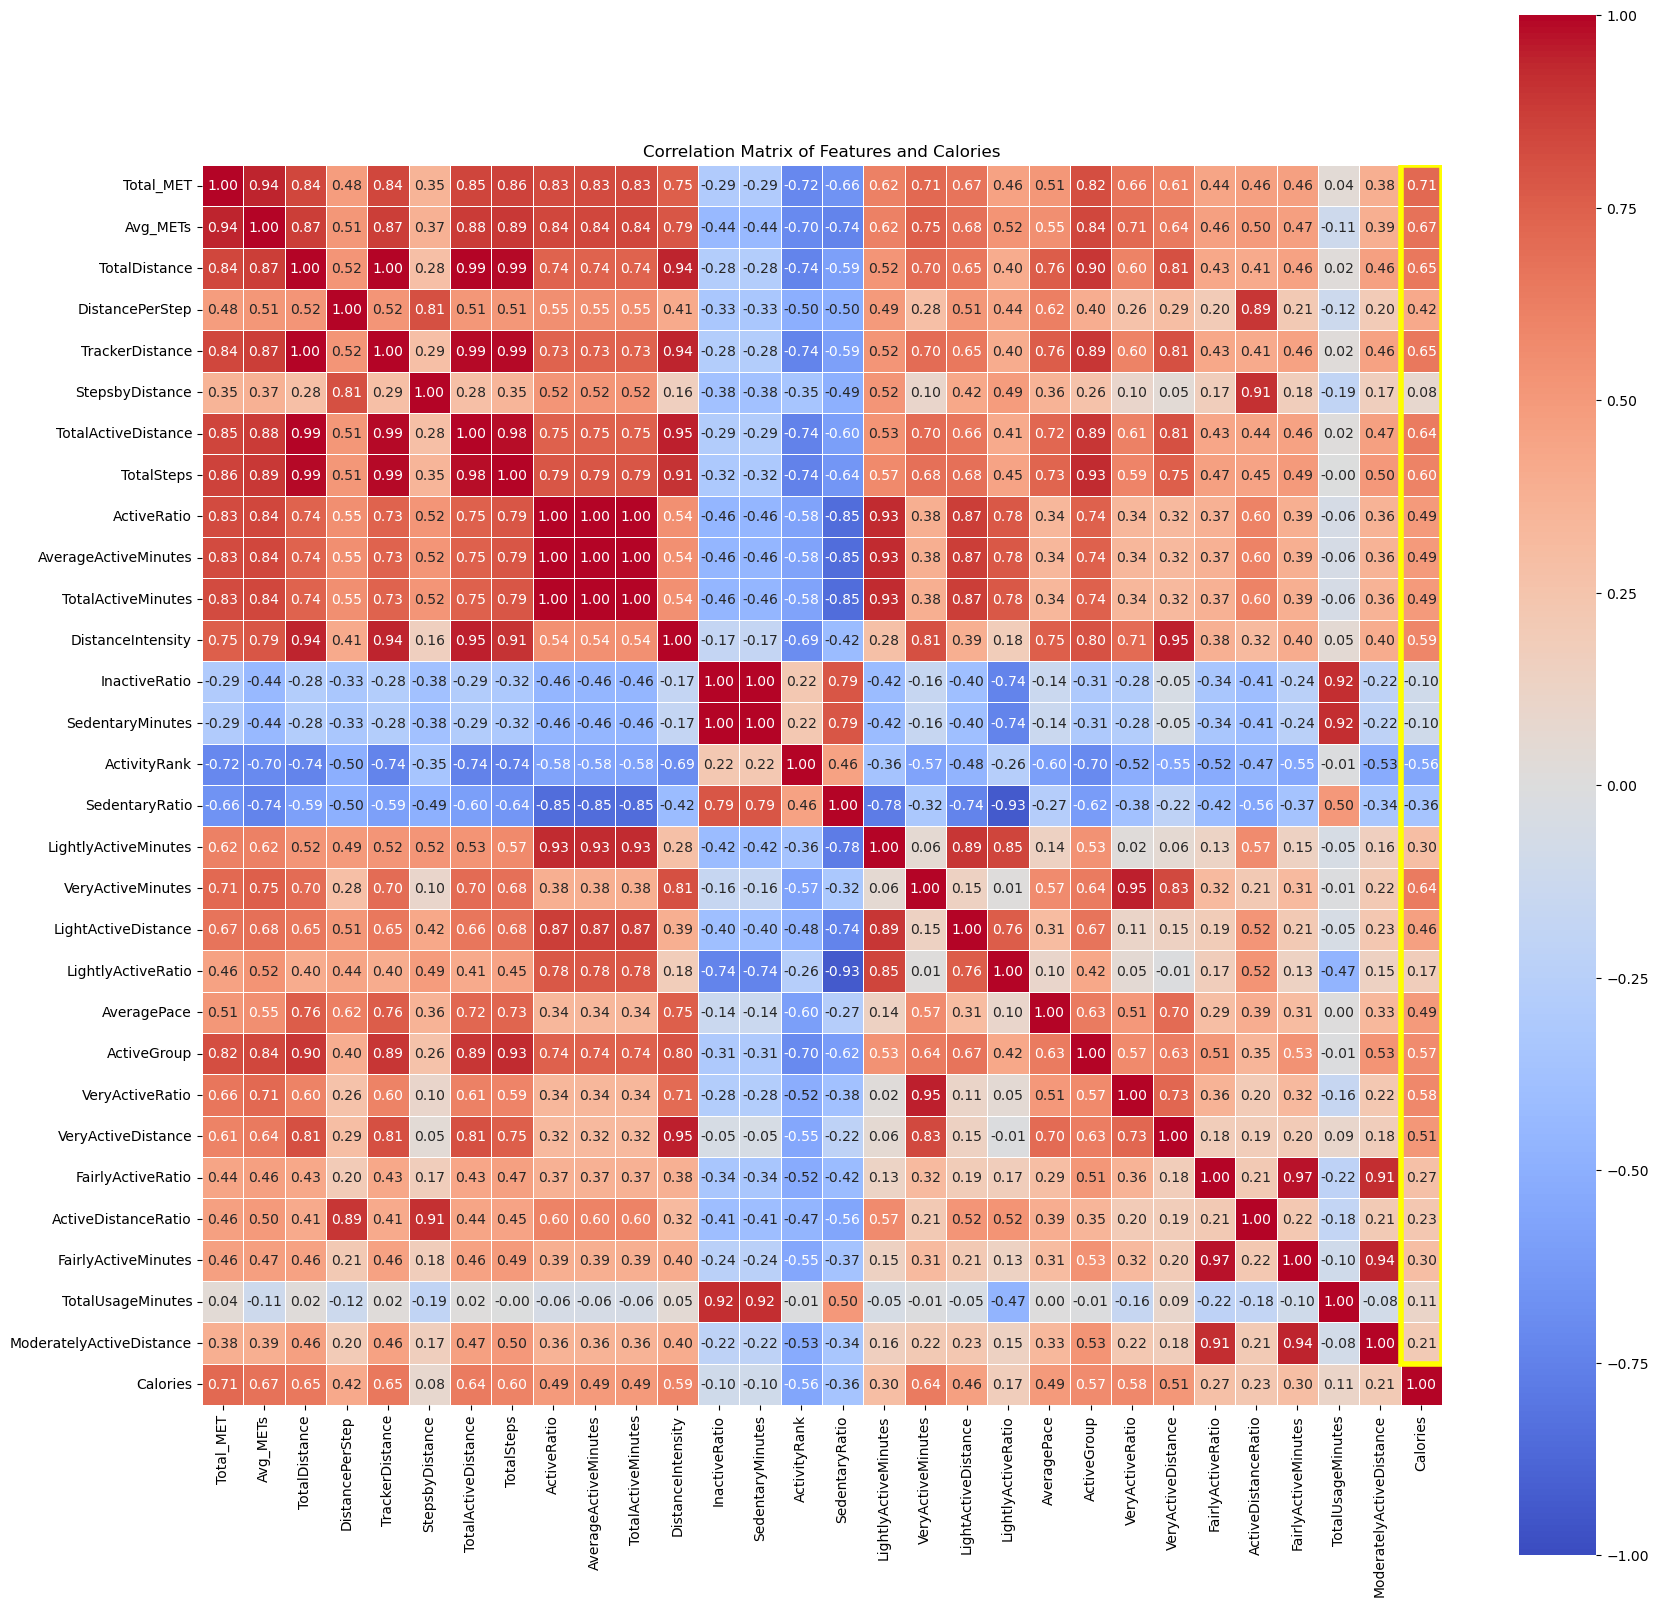

Top Features based on Correlation with Calories:
Total_MET              0.711077
Avg_METs               0.672500
TrackerDistance        0.652600
TotalDistance          0.652191
VeryActiveMinutes      0.636181
TotalActiveDistance    0.635289
TotalSteps             0.601834
DistanceIntensity      0.589984
VeryActiveRatio        0.580480
ActiveGroup            0.566788
Name: Calories, dtype: float64


In [3]:
import matplotlib.patches as patches

# Calculate the correlation matrix
correlation_matrix = train.corr()

# Get the absolute correlations with the target variable (Calories)
correlation_with_target = correlation_matrix["Calories"].abs()

# Plot the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=.5)

# Get the position of the "Calories" column in the matrix
calories_index = correlation_matrix.columns.get_loc("Calories")

# Create a rectangle patch to highlight the "Calories" column
rect = patches.Rectangle((calories_index, 0), 1, len(correlation_matrix) - 1, 
                         linewidth=4, edgecolor='yellow', facecolor='none')

# Add the rectangle to the plot
plt.gca().add_patch(rect)

plt.title("Correlation Matrix of Features and Calories")
plt.show()

# Sort features by correlation with Calories in descending order
sorted_correlation = correlation_with_target.sort_values(ascending=False)

# Select the top 10 features (excluding Calories itself)
top_features_with_values = sorted_correlation[1:11]  # Adjust as needed for more or fewer features

# Display the selected features and their correlation values
print("Top Features based on Correlation with Calories:")
print(top_features_with_values)

In [4]:
from sklearn.preprocessing import StandardScaler

selected_features = [
    'Total_MET', 'Avg_METs', 'TrackerDistance', 'TotalDistance', 
    'VeryActiveMinutes', 'TotalActiveDistance', 'TotalSteps', 
    'DistanceIntensity', 'VeryActiveRatio', 'ActiveGroup', 'Calories'
]

## Train Data

# Drop all other columns not in the selected features list
data_selected = train.drop(columns=[col for col in train.columns if col not in selected_features])

# Separate features and target variable for scaling
x_train = data_selected.drop(columns=['Calories'])
y_train = data_selected['Calories']

# Standardization (StandardScaler)
standard_scaler = StandardScaler()
x_train_standardized = standard_scaler.fit_transform(x_train)

# Convert to DataFrame for easier interpretation
x_train = pd.DataFrame(x_train_standardized, columns=x_train.columns)

In [5]:
## Test Data

# Drop all other columns not in the selected features list
data_selected = test.drop(columns=[col for col in test.columns if col not in selected_features])

# Separate features and target variable for scaling
x_test = data_selected.drop(columns=['Calories'])
y_test = data_selected['Calories']

# Standardization (StandardScaler)
standard_scaler = StandardScaler()
x_test_standardized = standard_scaler.fit_transform(x_test)

# Convert to DataFrame for easier interpretation
x_test = pd.DataFrame(x_test_standardized, columns=x_test.columns)

# Machine Learning

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time

## Random Forest Regressor

### Baseline

In [7]:
start_time_train = time.time()

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(x_train, y_train)

y_pred_rf = rf_model.predict(x_test)

end_time_train = time.time()

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

In [8]:
train_time_rf = end_time_train - start_time_train

print('RMSE:', rmse_rf)
print('R²  : ', r2_rf)
print(f"Training Time: {train_time_rf:.4f} seconds")

RMSE: 384.9447228338471
R²  :  0.706649690705705
Training Time: 0.4751 seconds


### Parameter Tuning

In [9]:
param_grid_rf = {
    'n_estimators': [100, 200],  # Number of trees
    'max_depth': [10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5],  # Minimum samples required to split a node
}

start_time_train = time.time()

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, verbose=2)

# Fit the model
grid_search_rf.fit(x_train, y_train)

end_time_train = time.time()

print("Best parameters Random Forest:", grid_search_rf.best_params_)

best_rf_model = grid_search_rf.best_estimator_

y_pred_rf = best_rf_model.predict(x_test)

best_rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
best_r2_rf = r2_score(y_test, y_pred_rf)

tuning_time_rf = end_time_train - start_time_train
print(f"Best RMSE: {best_rmse_rf:.4f}")
print(f"Best R²: {best_r2_rf:.4f}")
print(f"Tuning Time: {tuning_time_rf:.4f} seconds")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=5, n_est

## Gradient Boosting Regressor

### Baseline

In [10]:
start_time_train = time.time()
gb_model = GradientBoostingRegressor(random_state=42)

gb_model.fit(x_train, y_train)

y_pred_gb = gb_model.predict(x_test)

end_time_train = time.time()

train_time_gb = end_time_train - start_time_train
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

In [11]:
print('RMSE:', rmse_gb)
print('R²  : ', r2_gb)
print(f"Training Time: {train_time_gb} seconds")

RMSE: 394.92287864770566
R²  :  0.6912447167021015
Training Time: 0.18861603736877441 seconds


### Parameter Tuning

In [12]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

start_time_train = time.time()

grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, cv=5, verbose=2)

grid_search_gb.fit(x_train, y_train)

end_time_train = time.time()

print("Best parameters Gradient Boosting:", grid_search_gb.best_params_)

best_gb_model = grid_search_gb.best_estimator_

y_pred_gb = best_gb_model.predict(x_test)

best_rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
best_r2_gb = r2_score(y_test, y_pred_gb)

tuning_time_gb = end_time_train - start_time_train

print(f"Best RMSE (Gradient Boosting): {best_rmse_gb}")
print(f"Best R² (Gradient Boosting): {best_r2_gb}")
print(f"Tuning Time (Gradient Boosting): {tuning_time_gb} seconds")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=5, n_est

## Support Vector Regression (SVR)

### Baseline

In [13]:
start_time_train = time.time()
svm_model = SVR()

svm_model.fit(x_train, y_train)

y_pred_svm = svm_model.predict(x_test)

end_time_train = time.time()

train_time_svm = end_time_train - start_time_train
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
r2_svm = r2_score(y_test, y_pred_svm)

In [14]:
print('RMSE:', rmse_svm)
print('R²  : ', r2_svm)
print(f"Training Time: {train_time_svm:.4f} seconds")

RMSE: 702.7625253658409
R²  :  0.02229688373536587
Training Time: 0.0450 seconds


### Parameter Tuning

In [15]:
param_grid_svm = {
    'kernel': ['rbf', 'poly'],
    'C': [0.1, 1]
}

start_time_train = time.time()

grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, cv=5, verbose=2)

# Fit the model
grid_search_svm.fit(x_train, y_train)

end_time_train = time.time()

print("Best parameters SVM:", grid_search_svm.best_params_)

best_svm_model = grid_search_svm.best_estimator_

y_pred_svm = best_svm_model.predict(x_test)

best_rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
best_r2_svm = r2_score(y_test, y_pred_svm)

tuning_time_svm = end_time_train - start_time_train
print(f"Best RMSE: {best_rmse_svm:.4f}")
print(f"Best R²: {best_r2_svm:.4f}")
print(f"Tuning Time: {tuning_time_svm:.4f} seconds")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END ....................................C=1, kernel=rbf; total time=   0.0s
[CV] END ....................................C=1,

In [16]:
def convert_seconds(seconds):
  if seconds>60:
    minutes = seconds // 60
    remaining_seconds = seconds % 60
    return f"{int(minutes)} m {int(remaining_seconds)} s"
  elif seconds>1:
    return f"{int(seconds)} s"
  else:
    return f"{seconds:.3f} s"

In [17]:
model_names = ['Random Forest Regressor', 'Gradient Boosting Regressor', 'Support Vector Regression (SVR)']

baseline_rmse = [rmse_rf, rmse_gb, rmse_svm]

best_rmse = [best_rmse_rf, best_rmse_gb, best_rmse_svm]

baseline_r2 = [r2_rf, r2_gb, r2_svm]

best_r2 = [best_r2_rf, best_r2_gb, best_r2_svm]

training_times = [convert_seconds(train_time_rf), convert_seconds(train_time_gb),  convert_seconds(train_time_svm)]

tuning_times = [convert_seconds(tuning_time_rf), convert_seconds(tuning_time_gb), convert_seconds(tuning_time_svm)]

data = {
    'Model Name': model_names,
    'Baseline RMSE': baseline_rmse,
    'Baseline R²': baseline_r2,
    'Training Time': training_times,
    'Best RMSE': best_rmse,
    'Best R²': best_r2,
    'Tuning Time': tuning_times
}

results_df = pd.DataFrame(data)
results_df = results_df.sort_values(by=['Best RMSE','Best R²'],ascending=True).reset_index()

results_df['Baseline RMSE'] = results_df['Baseline RMSE'].apply(lambda x: '{:.5f}'.format(x))
results_df['Baseline R²'] = results_df['Baseline R²'].apply(lambda x: '{:.5f}'.format(x))
results_df['Best RMSE'] = results_df['Best RMSE'].apply(lambda x: '{:.5f}'.format(x))
results_df['Best R²'] = results_df['Best R²'].apply(lambda x: '{:.5f}'.format(x))

results_df = results_df.drop(columns=['index'])
results_df


,Model Name,Baseline RMSE,Baseline R²,Training Time,Best RMSE,Best R²,Tuning Time
0,Gradient Boosting Regressor,394.92288,0.69124,0.189 s,369.07323,0.73034,12 s
1,Random Forest Regressor,384.94472,0.70665,0.475 s,386.31822,0.70455,19 s
2,Support Vector Regression (SVR),702.76253,0.02230,0.045 s,615.79021,0.24932,0.388 s
